# Analysing Reliability of DOSPERT answers 20 LLMs

- We want to measure, for each LLM, how consistent it is in assigning probabilities across the 40-item answer patterns of a single human. Essentially: “Does the LLM consistently see the human’s answer pattern as more or less probable, or is it erratic?”

In [112]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import seaborn as sns
import pingouin as pg


# Initialize empty list to store DataFrames
dospert_dataframes = []

path = "outputs"  # folder with CSVs

for file in glob.glob(os.path.join(path, "*_dospert_scores.csv")):
    model_name = os.path.basename(file).replace("_dospert_scores.csv", "")
    
    # Read the CSV
    df = pd.read_csv(file)
    
    # Append to list
    dospert_dataframes.append(df)
    
# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)

print(f"\nMerged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
merged_dospert_data['logprob_predicted'] = merged_dospert_data.apply(
    lambda row: np.exp(row[str(row['human_number'])]), axis=1
)
# Define mapping dictionary
item_to_category = {
    1: "Social", 10: "Social", 16: "Social", 19: "Social", 23: "Social", 26: "Social", 34: "Social", 35: "Social",
    2: "Recreational", 6: "Recreational", 15: "Recreational", 17: "Recreational", 21: "Recreational", 31: "Recreational", 37: "Recreational", 38: "Recreational",
    3: "Gambling", 11: "Gambling", 22: "Gambling", 33: "Gambling",
    4: "Health", 8: "Health", 27: "Health", 29: "Health", 32: "Health", 36: "Health", 39: "Health", 40: "Health",
    5: "Ethical", 9: "Ethical", 12: "Ethical", 13: "Ethical", 14: "Ethical", 20: "Ethical", 25: "Ethical", 28: "Ethical",
    7: "Investment", 18: "Investment", 24: "Investment", 30: "Investment"
}

# Add a new column "domain"
merged_dospert_data["domain"] = merged_dospert_data["item"].map(item_to_category)

# Check column names
print(f"\nColumns: {list(merged_dospert_data.columns)}")

merged_dospert_data = merged_dospert_data[merged_dospert_data["flipped"] == "no"]

merged_dospert_data.groupby("model")["logprob_predicted"].nunique()


Merged DataFrame shape: (1208800, 11)
Total models: 20
Models included: ['Falcon-3-10B-Instruct', 'Falcon-3-1B-Instruct', 'Falcon-3-7B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct', 'Ministral-8B-Instruct-2410', 'Mistral-7B-Instruct-v0.3', 'OLMo-2-7B-Instruct', 'Qwen3-1.7B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM-1.7B-Instruct', 'SmolLM2-1.7B-Instruct', 'Unsloth-Qwen3-1.7B', 'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-3-1b-it', 'gemma-3-4b-it', 'zephyr-7b-beta']

Columns: ['human_number', '1', '2', '3', '4', '5', 'model', 'item', 'participant', 'flipped', 'experiment', 'logprob_predicted', 'domain']


model
Falcon-3-10B-Instruct         206
Falcon-3-1B-Instruct          180
Falcon-3-7B-Instruct          145
Llama-3.1-8B-Instruct          90
Llama-3.2-1B-Instruct          74
Llama-3.2-3B-Instruct          80
Ministral-8B-Instruct-2410    157
Mistral-7B-Instruct-v0.3      141
OLMo-2-7B-Instruct             71
Qwen3-1.7B                    213
Qwen3-4B                      281
Qwen3-8B                      218
SmolLM-1.7B-Instruct          199
SmolLM2-1.7B-Instruct         144
Unsloth-Qwen3-1.7B            213
gemma-2-2b-it                 126
gemma-2-9b-it                 192
gemma-3-1b-it                 180
gemma-3-4b-it                 246
zephyr-7b-beta                188
Name: logprob_predicted, dtype: int64

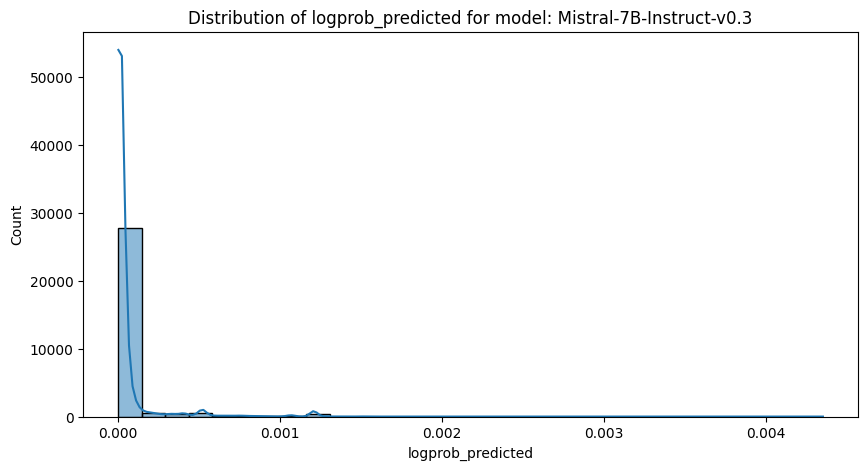

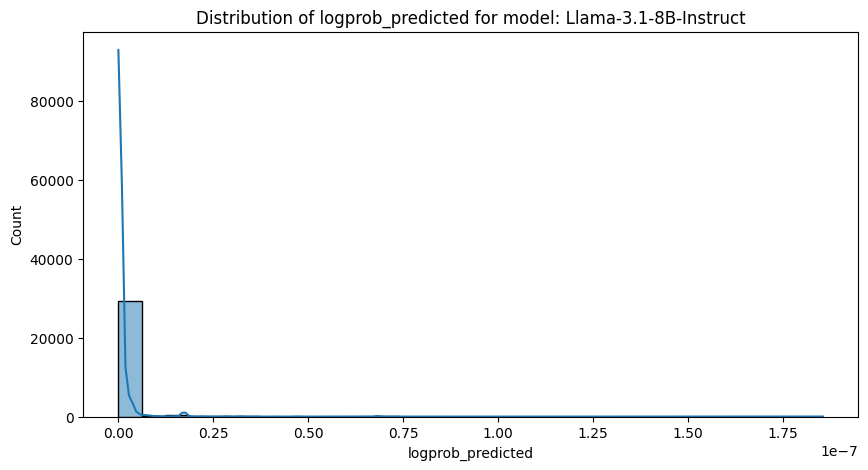

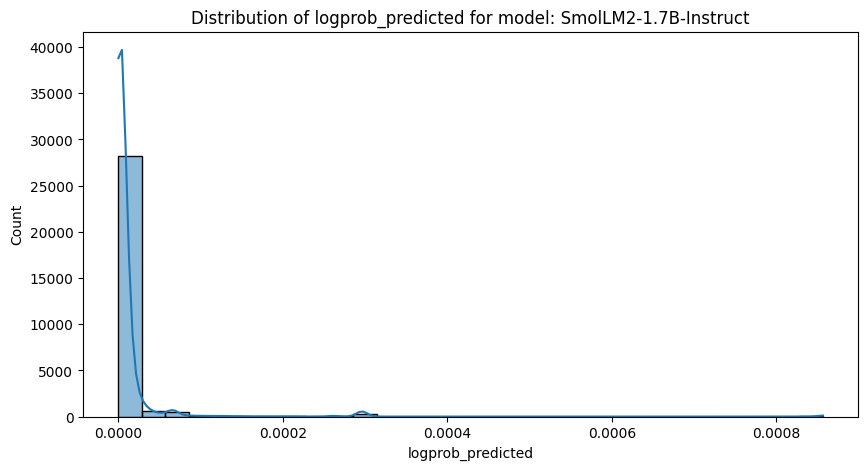

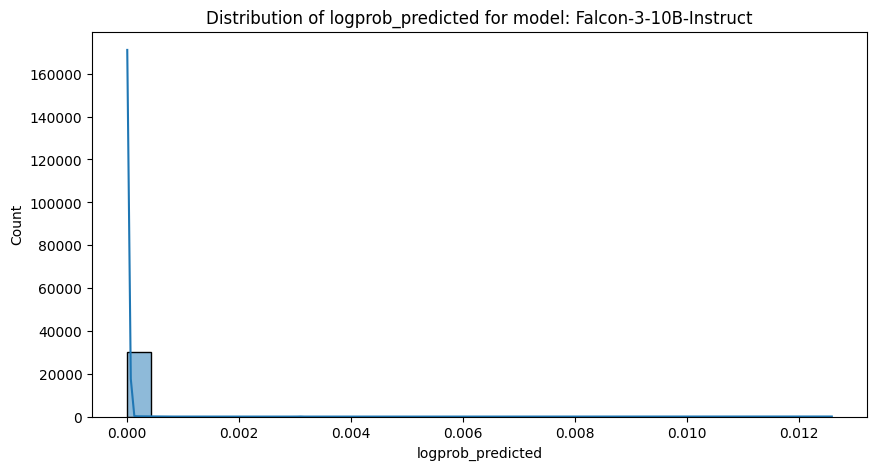

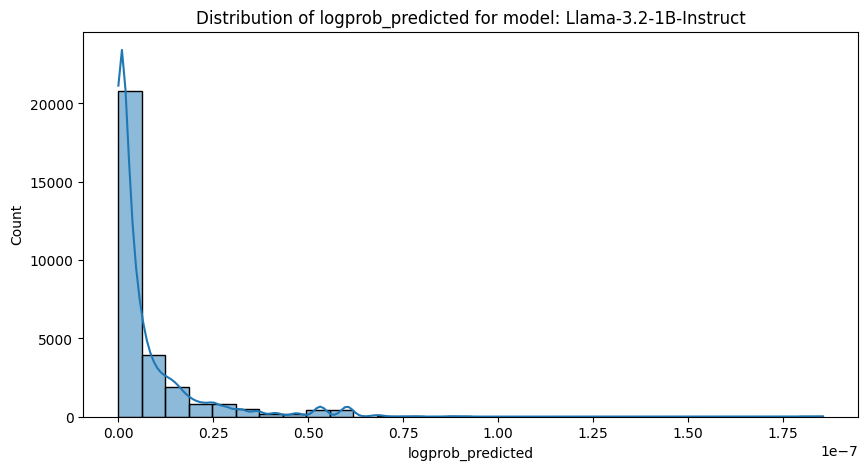

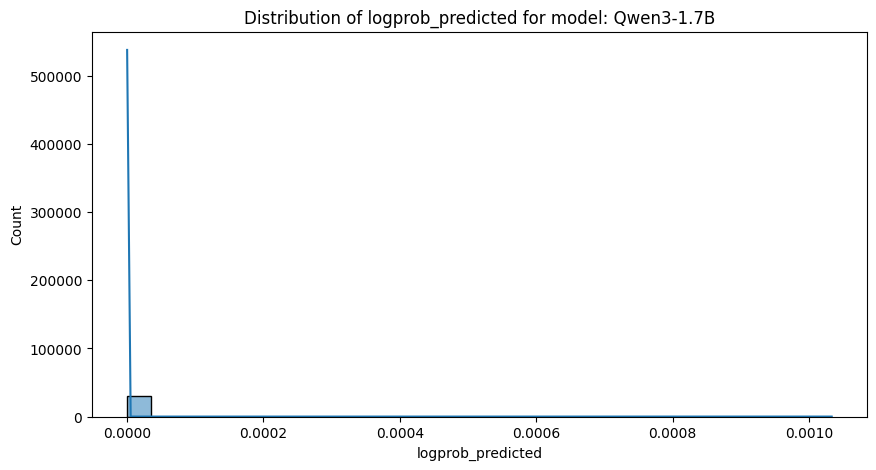

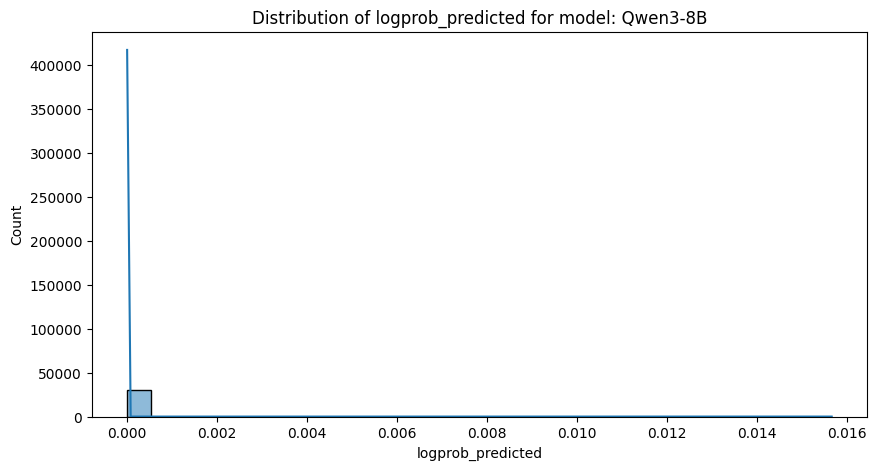

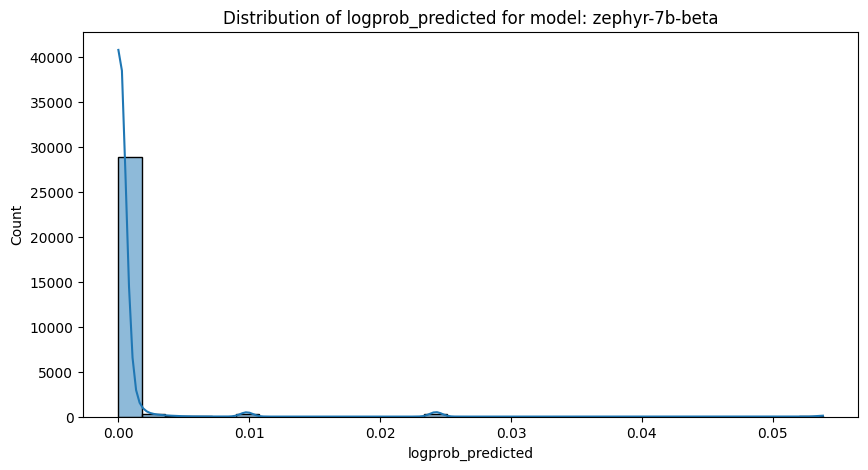

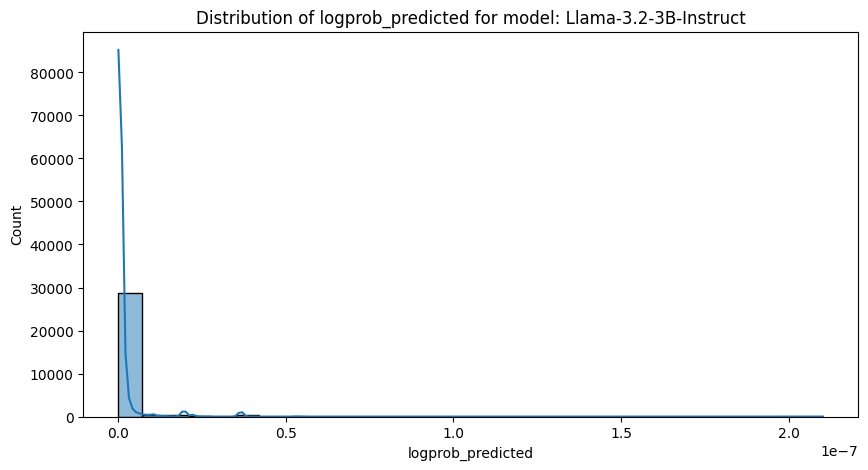

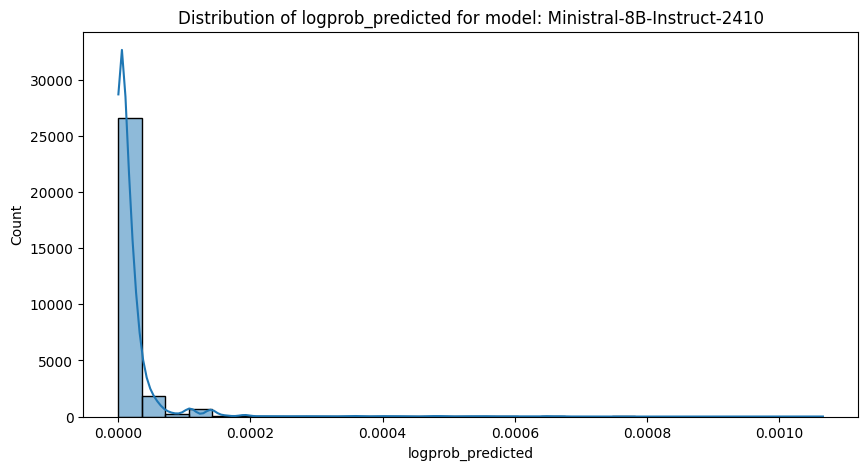

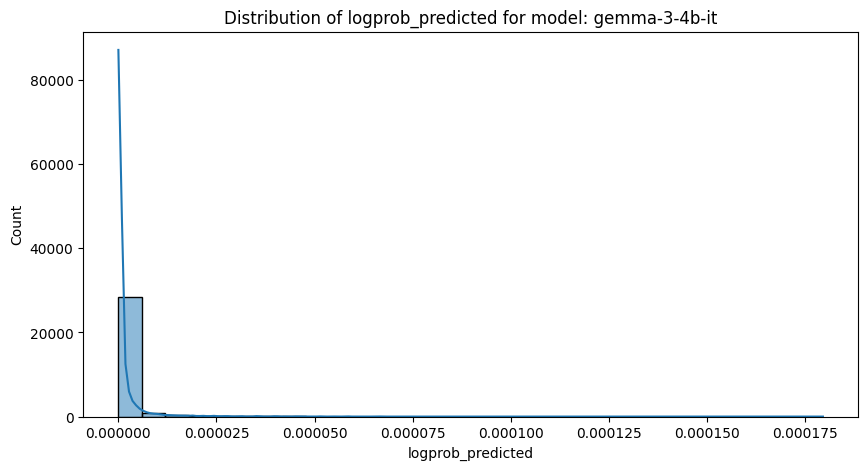

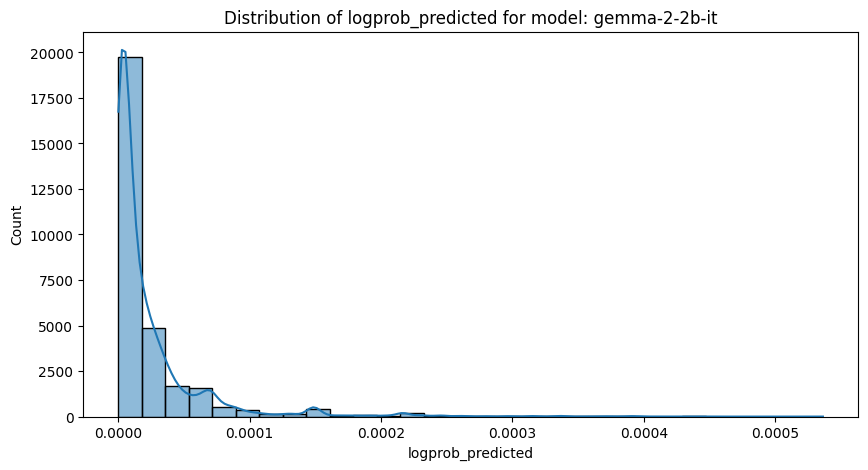

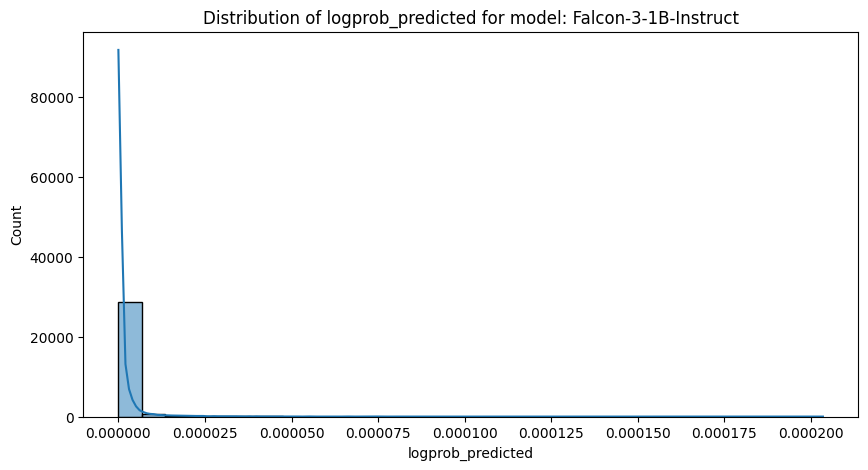

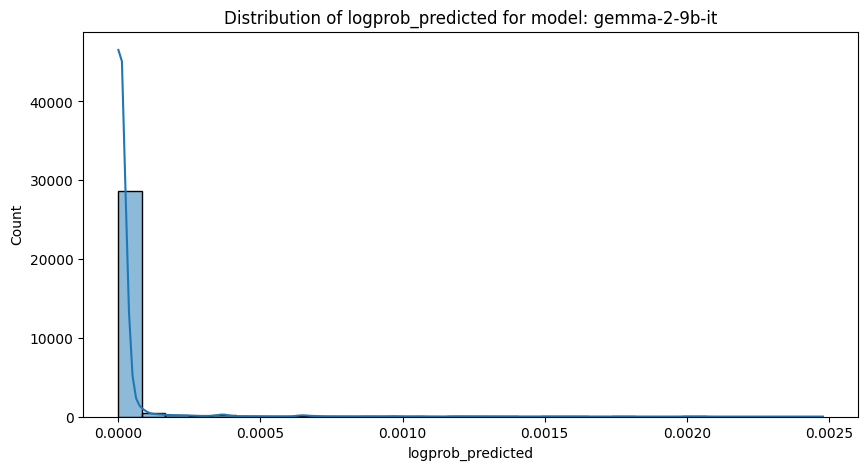

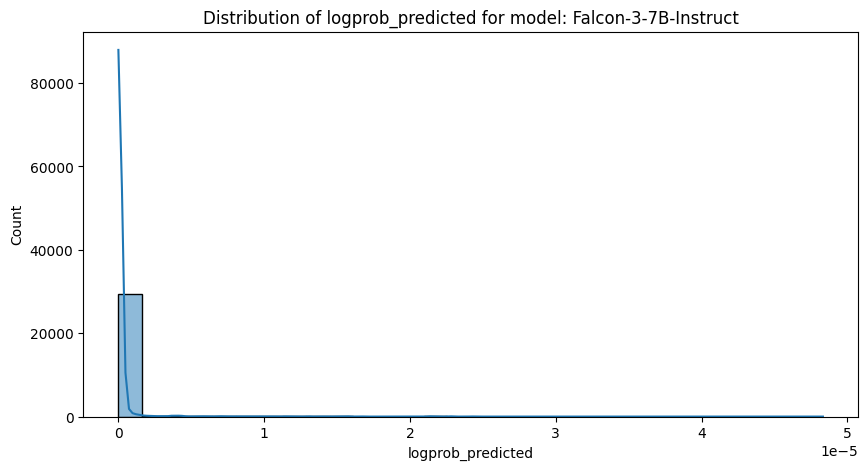

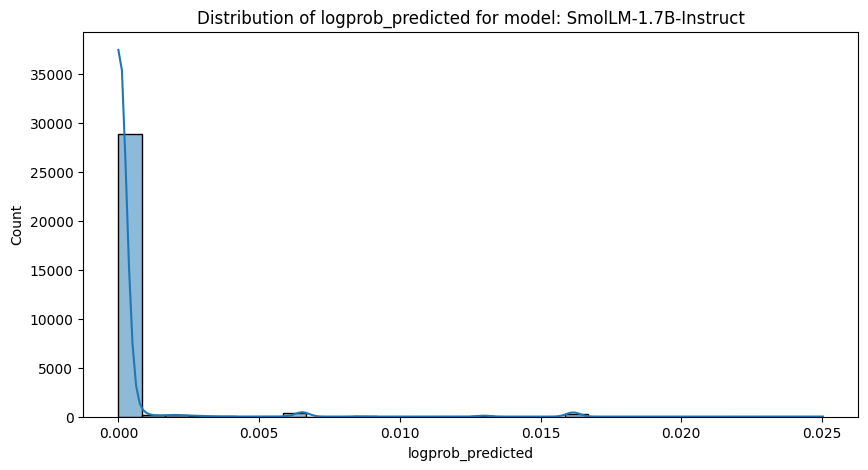

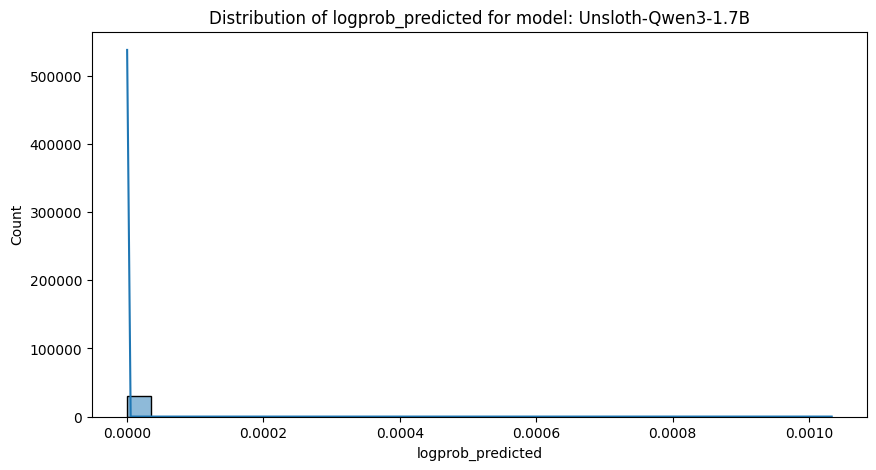

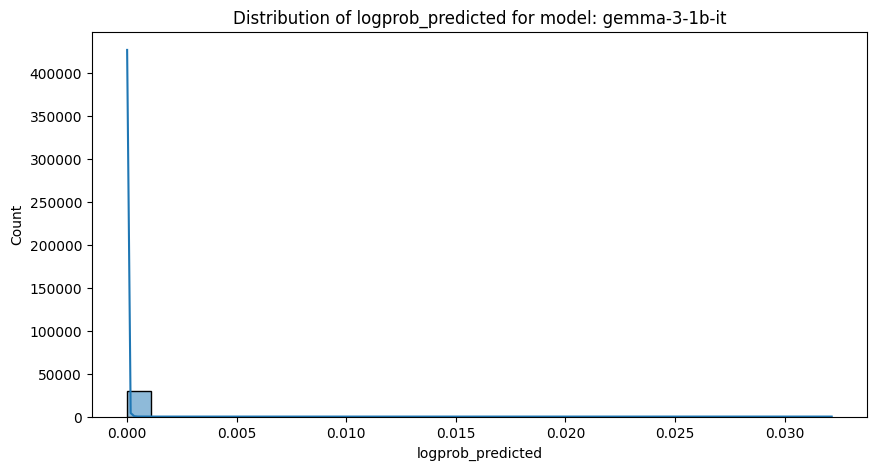

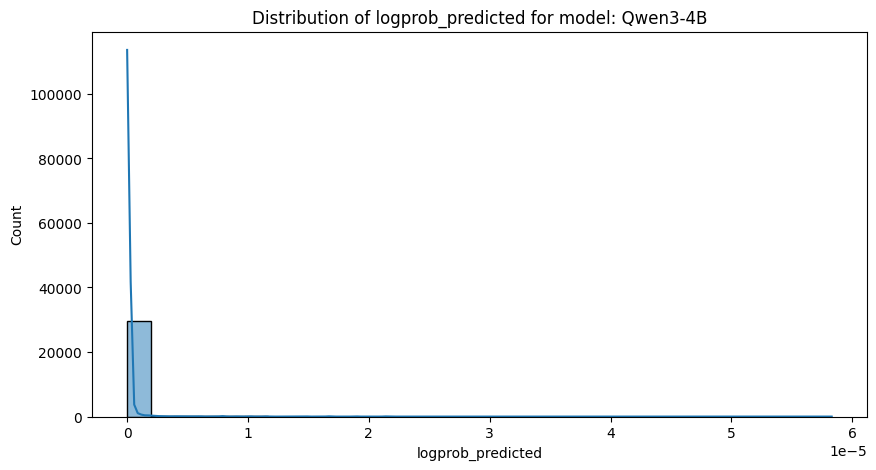

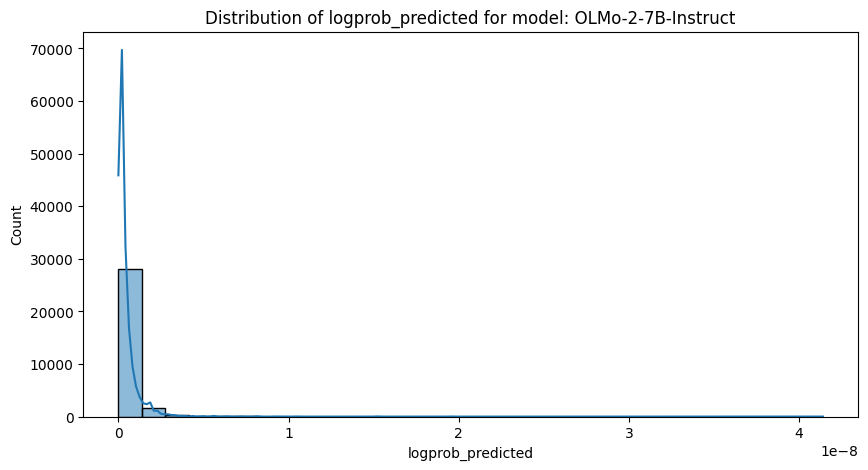

In [113]:
# Visualise distribution (focus on variance) per model of logprobs

model_names = merged_dospert_data['model'].unique()

for model_name in model_names:
    df_plot = merged_dospert_data[merged_dospert_data['model'] == model_name]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="logprob_predicted", kde=True, bins=30)  # KDE optional
    plt.title(f'Distribution of logprob_predicted for model: {model_name}')
    plt.xlabel('logprob_predicted')
    plt.ylabel('Count')
    plt.show()

In [114]:
# ---- Cronbach's alpha per domain ----

# dictionary to store results
results = []

# loop through domains
for domain, domain_data in merged_dospert_data.groupby("domain"):
    
    # loop through models within this domain
    for model, model_data in domain_data.groupby("model"):
        
        # pivot wide format for Cronbach's alpha
        df_wide_domains = model_data.pivot_table(
            index="participant",
            columns="item",
            values="logprob_predicted"
        )
        
        # drop rows with missing data
        df_wide_domains = df_wide_domains.dropna(axis=0)
        
        # calculate Cronbach's alpha
        if df_wide_domains.shape[1] > 1:  # need at least 2 items
            alpha, ci = pg.cronbach_alpha(df_wide_domains)
        else:
            alpha, ci = None, (None, None)  # not enough items to compute
        
        # store results
        results.append({
            "domain": domain,
            "model": model,
            "alpha": alpha,
            "alpha_CI": ci
        })

# convert to DataFrame
alpha_df = pd.DataFrame(results)


In [115]:
alpha_df

,domain,model,alpha,alpha_CI
0,Ethical,Falcon-3-10B-Instruct,0.079053,"[-0.024, 0.176]"
1,Ethical,Falcon-3-1B-Instruct,0.430065,"[0.366, 0.49]"
2,Ethical,Falcon-3-7B-Instruct,0.340173,"[0.266, 0.409]"
3,Ethical,Llama-3.1-8B-Instruct,0.063216,"[-0.042, 0.161]"
4,Ethical,Llama-3.2-1B-Instruct,0.721460,"[0.69, 0.751]"
...,...,...,...,...
115,Social,gemma-2-2b-it,0.368621,"[0.298, 0.435]"
116,Social,gemma-2-9b-it,0.172069,"[0.079, 0.259]"
117,Social,gemma-3-1b-it,0.015560,"[-0.095, 0.119]"
118,Social,gemma-3-4b-it,0.148075,"[0.053, 0.237]"


In [94]:
# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'logprob_predicted']

df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()

#df_wide: columns = wide format data with columns ['model', 'participant', item1, 2, ..., 40]

In [95]:
# ---- Cronbach's alpha ----
def cronbach_alpha(df):
    k = df.shape[1]
    item_vars = df.var(axis=0, ddof=1)
    total_var = df.sum(axis=1).var(ddof=1)
    return (k / (k - 1)) * (1 - item_vars.sum() / total_var)

alphas = {}
for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha = cronbach_alpha(scores)
    #print(f"Model {m}: alpha = {alpha:.3f}")
    alphas[m] = alpha

alpha_df = pd.DataFrame(list(alphas.items()), columns=["model", "alpha"])

In [96]:
# ---- split-half reliability -----

def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    colnames = df_items.columns
    results = []
    
    for _ in range(n_splits):
        shuffled = list(colnames)
        random.shuffle(shuffled)
        half1, half2 = shuffled[:k//2], shuffled[k//2:]
        
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)
        
        r, _ = pearsonr(s1, s2)
        if np.isfinite(r): 
            r_sb = (2 * r) / (1 + r)
            results.append(r_sb)
    
    return np.mean(results), np.std(results)

split_results = {}

for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

In [97]:
# ---- ICC -----

df_long = merged_dospert_data.copy()

def compute_icc(df_long, model):
    """Compute ICC for one model (participant random effect)."""
    sub = df_long[df_long["model"] == model]
    # Random intercept model: logprob ~ 1 + (1|participant)
    md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
    mdf = md.fit(reml=True)
    
    var_participant = mdf.cov_re.iloc[0,0]
    var_residual = mdf.scale
    icc = var_participant / (var_participant + var_residual)
    return icc

icc_results = {}
for m in df_long["model"].unique():
    icc_results[m] = compute_icc(df_long, m)

icc_df = pd.DataFrame(list(icc_results.items()), columns=["model", "icc"])


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warning

In [98]:
results_df = alpha_df.merge(split_df, on="model").merge(icc_df, on="model")
results_df

,model,alpha,split_half_mean,split_half_sd,icc
0,Falcon-3-10B-Instruct,0.897975,0.902608,0.017104,1.334866e-01
1,Falcon-3-1B-Instruct,0.909796,0.915632,0.011930,6.696331e-02
2,Falcon-3-7B-Instruct,0.784819,0.793291,0.026933,5.444889e-02
3,Llama-3.1-8B-Instruct,0.794893,0.796322,0.024183,3.167047e-02
4,Llama-3.2-1B-Instruct,0.866807,0.872378,0.014399,6.069513e-02
5,Llama-3.2-3B-Instruct,0.772057,0.771839,0.026623,2.666412e-02
6,Ministral-8B-Instruct-2410,0.837368,0.843490,0.019562,6.207028e-02
7,Mistral-7B-Instruct-v0.3,0.182321,0.211337,0.091112,1.312167e-10
8,OLMo-2-7B-Instruct,0.588192,0.595001,0.051721,8.591547e-03
9,Qwen3-1.7B,0.624030,0.628434,0.053296,1.395057e-02


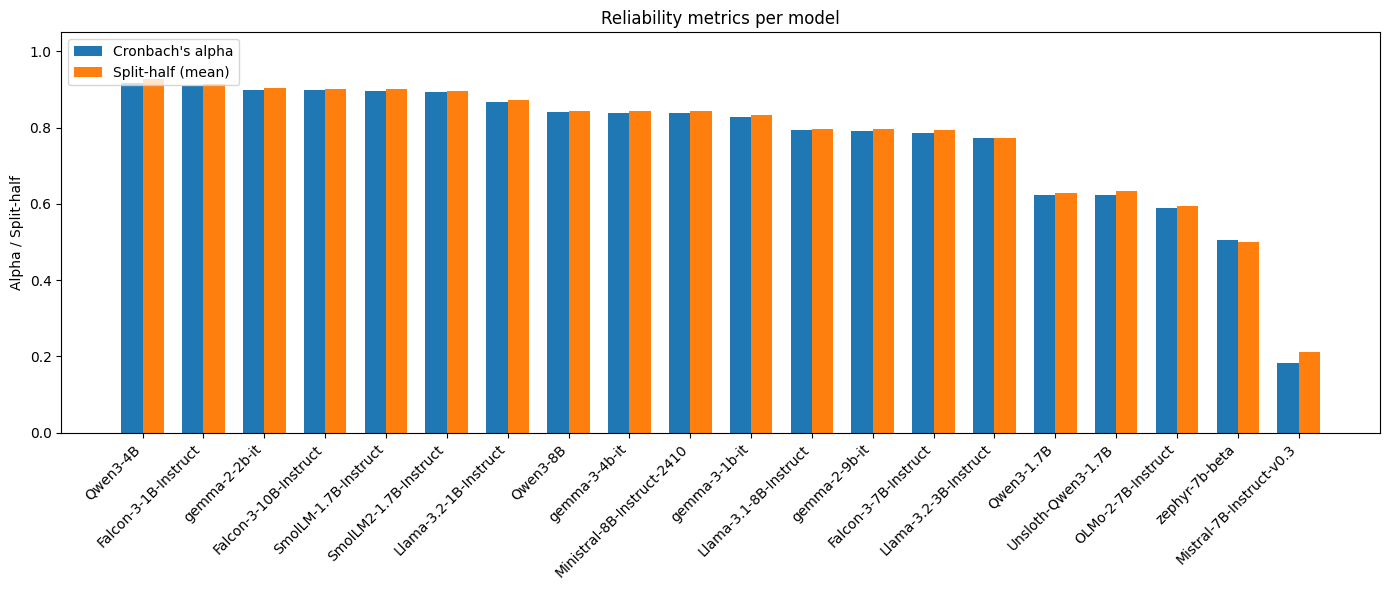

In [99]:
# Sort models by alpha for better readability
df_sorted = results_df.sort_values("alpha", ascending=False)

x = np.arange(len(df_sorted))  # positions for models
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(14,6))

# Bars for alpha and split-half
ax1.bar(x - width/2, df_sorted["alpha"], width, label="Cronbach's alpha")
ax1.bar(x + width/2, df_sorted["split_half_mean"], width, label="Split-half (mean)")

ax1.set_ylabel("Alpha / Split-half")
ax1.set_xticks(x)
ax1.set_xticklabels(df_sorted["model"], rotation=45, ha="right")
ax1.set_ylim(0, 1.05)
ax1.legend(loc="upper left")
ax1.set_title("Reliability metrics per model")

# Optional: plot ICC on secondary axis
# ax2 = ax1.twinx()
# ax2.plot(x, df_sorted["icc"], color="red", marker="o", linestyle='-', label="ICC")
# ax2.set_ylabel("ICC")
# ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


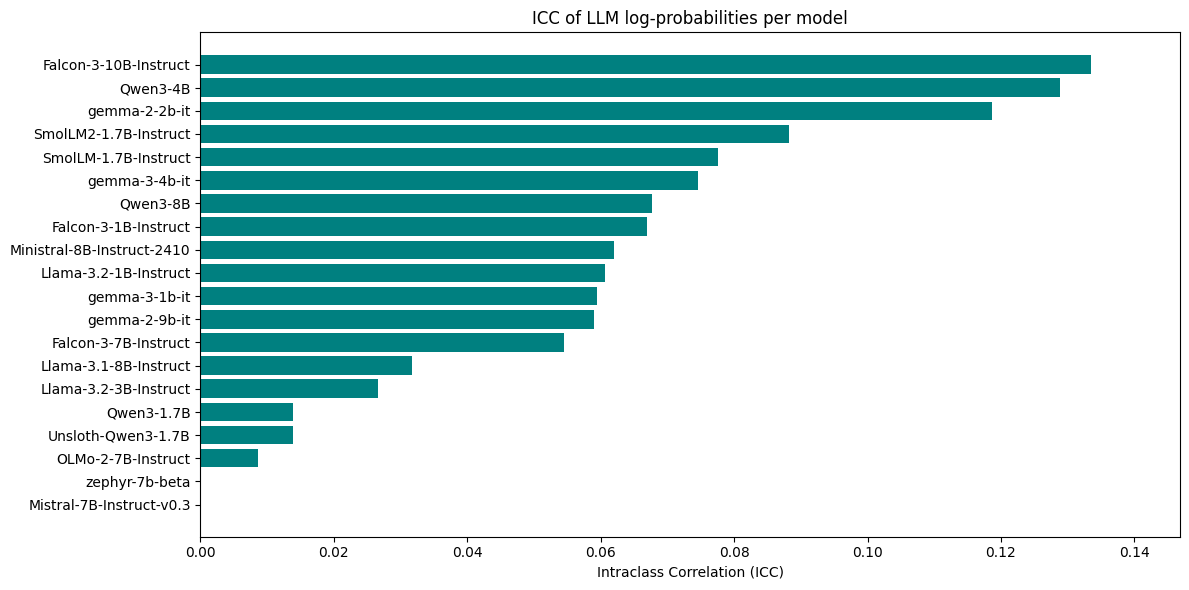

In [100]:
# Sort models by ICC for easier visualization
icc_sorted = results_df.sort_values("icc", ascending=True)
y = np.arange(len(icc_sorted))

plt.figure(figsize=(12,6))
plt.barh(y, icc_sorted["icc"], color="teal")
plt.yticks(y, icc_sorted["model"])
plt.xlabel("Intraclass Correlation (ICC)")
plt.title("ICC of LLM log-probabilities per model")
plt.xlim(0, icc_sorted["icc"].max()*1.1)  # add 10% padding
plt.tight_layout()
plt.show()

#ICC quantifies the proportion of variance in the LLM’s assigned log-probabilities that is attributable to differences between participants, as opposed to random variation across items or noise.

count     40.000000
mean      23.762857
std       30.690009
min        3.360094
25%        8.001983
50%       12.637948
75%       21.257204
max      163.149555
Name: logprob_predicted, dtype: float64
count    748.000000
mean     -22.504821
std        2.369480
min      -32.337500
25%      -23.835156
50%      -22.025000
75%      -20.820312
max      -17.981250
Name: logprob_predicted, dtype: float64


<Axes: ylabel='logprob_predicted'>

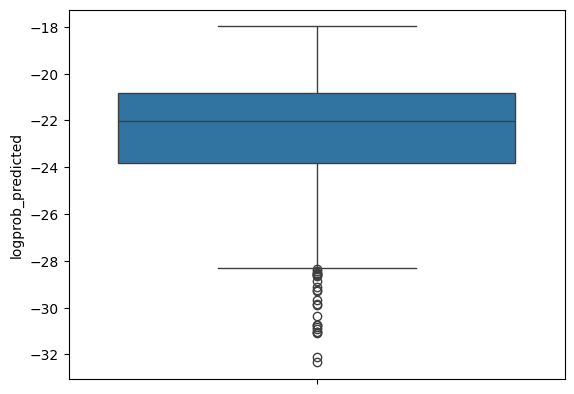

In [101]:
# is ICC so low because there is simply no variance between the logprobs assigned to different participants?

df_long_Qwen3_4b = df_long[df_long["model"] == "Qwen3-4B"]

participant_var_per_item = df_long_Qwen3_4b.groupby("item")["logprob_predicted"].var()
print(participant_var_per_item.describe())

participant_means = df_long_Qwen3_4b.groupby("participant")["logprob_predicted"].mean()
print(participant_means.describe())


import seaborn as sns
sns.boxplot(participant_means)

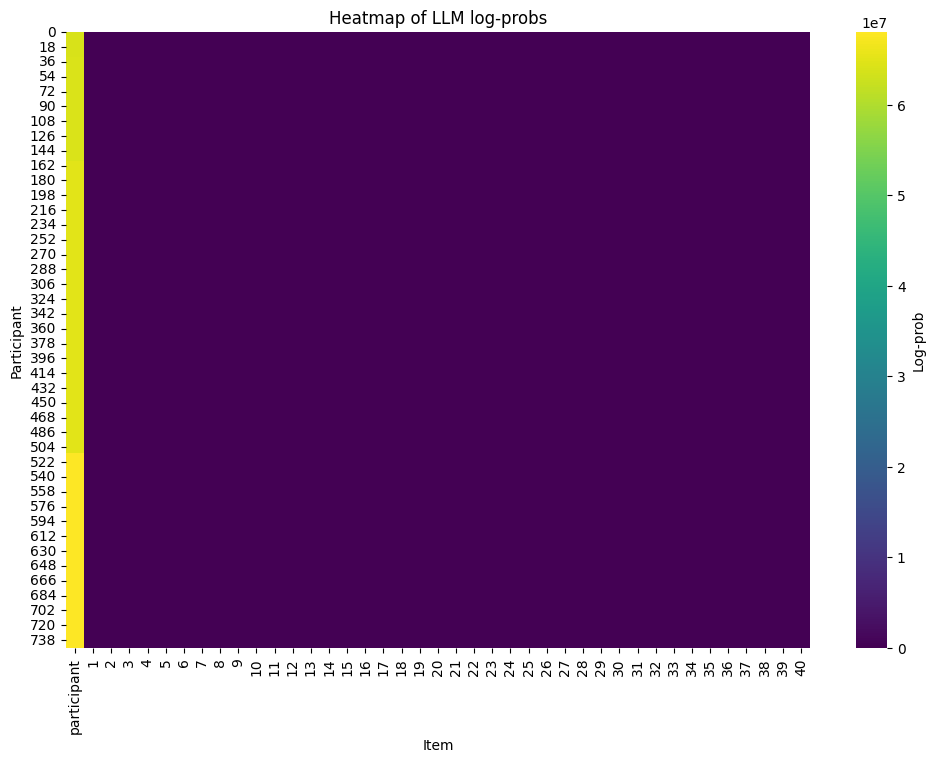

In [102]:
# Pivot to participants × items
heatmap_df = df_long_Qwen3_4b.pivot_table(
    index=['participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()


plt.figure(figsize=(12,8))
sns.heatmap(heatmap_df, cmap="viridis", cbar_kws={'label':'Log-prob'})
plt.xlabel("Item")
plt.ylabel("Participant")
plt.title("Heatmap of LLM log-probs")
plt.show()


In [103]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# Initialize empty list to store DataFrames
dospert_dataframes = []
path = "outputs"  # folder with CSVs

for file in glob.glob(os.path.join(path, "*_dospert_scores.csv")):
    model_name = os.path.basename(file).replace("_dospert_scores.csv", "")
    # Read the CSV
    df = pd.read_csv(file)
    # Append to list
    dospert_dataframes.append(df)

# Concatenate all DataFrames into one big DataFrame
merged_dospert_data = pd.concat(dospert_dataframes, ignore_index=True)
print(f"\nMerged DataFrame shape: {merged_dospert_data.shape}")
print(f"Total models: {merged_dospert_data['model'].nunique()}")
print(f"Models included: {sorted(merged_dospert_data['model'].unique())}")

# add column with predicted logprob for actual human answers
merged_dospert_data['logprob_predicted'] = merged_dospert_data.apply(
    lambda row: row[str(row['human_number'])], axis=1
)

# Check column names
print(f"\nColumns: {list(merged_dospert_data.columns)}")

# merged_dospert_data: long format with columns ['participant', 'item', 'model', 'logprob_predicted']
df_wide = merged_dospert_data.pivot_table(
    index=['model', 'participant'],
    columns='item',
    values='logprob_predicted'
).reset_index()

# ---- IMPROVED Cronbach's alpha ----
def cronbach_alpha(df):
    """
    Compute Cronbach's alpha with better numerical stability
    """
    # Remove any rows with missing values
    df_clean = df.dropna()
    if df_clean.empty:
        return np.nan
    
    k = df_clean.shape[1]  # number of items
    if k < 2:
        return np.nan
    
    # Calculate item variances
    item_vars = df_clean.var(axis=0, ddof=1)
    
    # Calculate total score variance
    total_scores = df_clean.sum(axis=1)
    total_var = total_scores.var(ddof=1)
    
    # Handle edge cases
    if total_var == 0:
        return np.nan
    
    # Cronbach's alpha formula
    alpha = (k / (k - 1)) * (1 - item_vars.sum() / total_var)
    return alpha

alphas = {}
for m, sub in df_wide.groupby("model"):
    scores = sub.drop(columns=["model", "participant"])
    alpha = cronbach_alpha(scores)
    alphas[m] = alpha

alpha_df = pd.DataFrame(list(alphas.items()), columns=["model", "alpha"])

# ---- FIXED split-half reliability -----
def split_half_reliability(df_items, n_splits=100):
    """Compute average split-half reliability (Spearman–Brown corrected)."""
    k = df_items.shape[1]
    if k < 2:
        return np.nan, np.nan
    
    colnames = df_items.columns.tolist()
    results = []
    
    for _ in range(n_splits):  # FIXED: was "for * in range(n*splits)"
        shuffled = colnames.copy()
        random.shuffle(shuffled)
        
        # Split into two halves
        half1, half2 = shuffled[:k//2], shuffled[k//2:k//2*2]  # Ensure equal lengths
        
        if len(half1) == 0 or len(half2) == 0:
            continue
            
        s1 = df_items[half1].sum(axis=1)
        s2 = df_items[half2].sum(axis=1)
        
        # Check for zero variance
        if s1.var() == 0 or s2.var() == 0:
            continue
            
        r, p_value = pearsonr(s1, s2)
        
        if np.isfinite(r) and r > -1:  # Avoid invalid correlations
            # Spearman-Brown correction
            r_sb = (2 * r) / (1 + r) if (1 + r) != 0 else np.nan
            if np.isfinite(r_sb):
                results.append(r_sb)
    
    if len(results) == 0:
        return np.nan, np.nan
    
    return np.mean(results), np.std(results)

split_results = {}
for m, sub in df_wide.groupby("model"):
    items = sub.drop(columns=["model", "participant"])
    mean_rsb, sd_rsb = split_half_reliability(items)
    split_results[m] = (mean_rsb, sd_rsb)

split_df = pd.DataFrame([
    {"model": m, "split_half_mean": mean, "split_half_sd": sd}
    for m, (mean, sd) in split_results.items()
])

# ---- IMPROVED ICC -----
def compute_icc(df_long, model):
    """Compute ICC for one model (participant random effect)."""
    sub = df_long[df_long["model"] == model].copy()
    
    # Check if we have enough data
    if len(sub) == 0 or sub['participant'].nunique() < 2:
        return np.nan
    
    try:
        # Random intercept model: logprob ~ 1 + (1|participant)
        md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
        mdf = md.fit(reml=True, disp=False)  # Suppress convergence warnings
        
        # Extract variance components
        var_participant = mdf.cov_re.iloc[0, 0]
        var_residual = mdf.scale
        
        # Calculate ICC
        icc = var_participant / (var_participant + var_residual)
        return icc
        
    except Exception as e:
        print(f"Warning: ICC computation failed for model {model}: {e}")
        return np.nan

icc_results = {}
for m in df_long["model"].unique():
    icc_results[m] = compute_icc(df_long, m)

icc_df = pd.DataFrame(list(icc_results.items()), columns=["model", "icc"])

# Merge all results
results_df = alpha_df.merge(split_df, on="model").merge(icc_df, on="model")

# Sort by alpha for better readability
results_df = results_df.sort_values('alpha', ascending=False)

print("\n" + "="*60)
print("RELIABILITY ANALYSIS RESULTS")
print("="*60)
print(results_df.round(4))

# ---- INTERPRETATION HELPER ----
def interpret_reliability(alpha, split_half, icc):
    """Provide interpretation guidelines for reliability measures"""
    interpretations = []
    
    # Cronbach's Alpha interpretation
    if alpha >= 0.9:
        alpha_interp = "Excellent"
    elif alpha >= 0.8:
        alpha_interp = "Good"
    elif alpha >= 0.7:
        alpha_interp = "Acceptable"
    elif alpha >= 0.6:
        alpha_interp = "Questionable"
    else:
        alpha_interp = "Poor"
    
    # Split-half interpretation (similar scale)
    if split_half >= 0.9:
        split_interp = "Excellent"
    elif split_half >= 0.8:
        split_interp = "Good"
    elif split_half >= 0.7:
        split_interp = "Acceptable"
    elif split_half >= 0.6:
        split_interp = "Questionable"
    else:
        split_interp = "Poor"
    
    # ICC interpretation
    if icc >= 0.75:
        icc_interp = "Excellent"
    elif icc >= 0.6:
        icc_interp = "Good"
    elif icc >= 0.4:
        icc_interp = "Fair"
    else:
        icc_interp = "Poor"
    
    return alpha_interp, split_interp, icc_interp

# Add interpretations to results
results_df[['alpha_interp', 'split_half_interp', 'icc_interp']] = results_df.apply(
    lambda row: interpret_reliability(row['alpha'], row['split_half_mean'], row['icc']), 
    axis=1, result_type='expand'
)

print("\n" + "="*60)
print("RELIABILITY INTERPRETATIONS")
print("="*60)
results_df[['model', 'alpha', 'alpha_interp', 'split_half_mean', 'split_half_interp', 'icc', 'icc_interp']].round(4)


Merged DataFrame shape: (1208800, 11)
Total models: 20
Models included: ['Falcon-3-10B-Instruct', 'Falcon-3-1B-Instruct', 'Falcon-3-7B-Instruct', 'Llama-3.1-8B-Instruct', 'Llama-3.2-1B-Instruct', 'Llama-3.2-3B-Instruct', 'Ministral-8B-Instruct-2410', 'Mistral-7B-Instruct-v0.3', 'OLMo-2-7B-Instruct', 'Qwen3-1.7B', 'Qwen3-4B', 'Qwen3-8B', 'SmolLM-1.7B-Instruct', 'SmolLM2-1.7B-Instruct', 'Unsloth-Qwen3-1.7B', 'gemma-2-2b-it', 'gemma-2-9b-it', 'gemma-3-1b-it', 'gemma-3-4b-it', 'zephyr-7b-beta']

Columns: ['human_number', '1', '2', '3', '4', '5', 'model', 'item', 'participant', 'flipped', 'experiment', 'logprob_predicted']


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warning


RELIABILITY ANALYSIS RESULTS
                         model   alpha  split_half_mean  split_half_sd     icc
10                    Qwen3-4B  0.9611           0.9706         0.0089  0.1289
11                    Qwen3-8B  0.9371           0.9441         0.0107  0.0677
13       SmolLM2-1.7B-Instruct  0.9045           0.9156         0.0220  0.0883
12        SmolLM-1.7B-Instruct  0.8909           0.8989         0.0239  0.0776
1         Falcon-3-1B-Instruct  0.8899           0.8965         0.0282  0.0670
15               gemma-2-2b-it  0.8896           0.8991         0.0289  0.1187
4        Llama-3.2-1B-Instruct  0.8792           0.8846         0.0202  0.0607
0        Falcon-3-10B-Instruct  0.8782           0.8821         0.0173  0.1335
18               gemma-3-4b-it  0.8729           0.8801         0.0351  0.0745
17               gemma-3-1b-it  0.8553           0.8629         0.0459  0.0595
5        Llama-3.2-3B-Instruct  0.8460           0.8487         0.0215  0.0267
3        Llama-3.1-8B-

,model,alpha,alpha_interp,split_half_mean,split_half_interp,icc,icc_interp
10,Qwen3-4B,0.9611,Excellent,0.9706,Excellent,0.1289,Poor
11,Qwen3-8B,0.9371,Excellent,0.9441,Excellent,0.0677,Poor
13,SmolLM2-1.7B-Instruct,0.9045,Excellent,0.9156,Excellent,0.0883,Poor
12,SmolLM-1.7B-Instruct,0.8909,Good,0.8989,Good,0.0776,Poor
1,Falcon-3-1B-Instruct,0.8899,Good,0.8965,Good,0.0670,Poor
15,gemma-2-2b-it,0.8896,Good,0.8991,Good,0.1187,Poor
4,Llama-3.2-1B-Instruct,0.8792,Good,0.8846,Good,0.0607,Poor
0,Falcon-3-10B-Instruct,0.8782,Good,0.8821,Good,0.1335,Poor
18,gemma-3-4b-it,0.8729,Good,0.8801,Good,0.0745,Poor
17,gemma-3-1b-it,0.8553,Good,0.8629,Good,0.0595,Poor


In [104]:
# Diagnostic code to understand the ICC convergence warnings

def detailed_icc_analysis(df_long, model):
    """
    Compute ICC with detailed diagnostics to understand convergence issues
    """
    sub = df_long[df_long["model"] == model].copy()
    
    print(f"\n=== DIAGNOSTIC ANALYSIS FOR {model} ===")
    print(f"Number of observations: {len(sub)}")
    print(f"Number of participants: {sub['participant'].nunique()}")
    print(f"Number of items: {sub['item'].nunique()}")
    
    # Check logprob distribution
    logprobs = sub['logprob_predicted']
    print(f"\nLogprob statistics:")
    print(f"  Mean: {logprobs.mean():.6f}")
    print(f"  Std:  {logprobs.std():.6f}")
    print(f"  Min:  {logprobs.min():.6f}")
    print(f"  Max:  {logprobs.max():.6f}")
    print(f"  Range: {logprobs.max() - logprobs.min():.6f}")
    
    # Check participant-level variation
    participant_means = sub.groupby('participant')['logprob_predicted'].mean()
    print(f"\nParticipant-level variation:")
    print(f"  Between-participant std: {participant_means.std():.6f}")
    print(f"  Within-participant std:  {sub.groupby('participant')['logprob_predicted'].std().mean():.6f}")
    
    # Check if there's any meaningful variation between participants
    participant_range = participant_means.max() - participant_means.min()
    print(f"  Range of participant means: {participant_range:.6f}")
    
    try:
        # Fit the model with more detailed output
        md = mixedlm("logprob_predicted ~ 1", sub, groups=sub["participant"])
        mdf = md.fit(reml=True, disp=False)
        
        # Extract variance components
        var_participant = mdf.cov_re.iloc[0, 0]
        var_residual = mdf.scale
        
        print(f"\nVariance Components:")
        print(f"  Participant variance: {var_participant:.8f}")
        print(f"  Residual variance:    {var_residual:.8f}")
        print(f"  Total variance:       {var_participant + var_residual:.8f}")
        
        # Calculate ICC
        icc = var_participant / (var_participant + var_residual)
        print(f"  ICC: {icc:.6f}")
        
        # Check if we're at the boundary
        if var_participant < 1e-6:
            print("  ⚠️  BOUNDARY ISSUE: Participant variance ≈ 0")
            print("     This means the model cannot detect meaningful individual differences")
        
        # Alternative ICC calculation using ANOVA approach
        from scipy import stats
        
        # One-way ANOVA to get between vs within group variance
        participant_groups = [group['logprob_predicted'].values for name, group in sub.groupby('participant')]
        f_stat, p_val = stats.f_oneway(*participant_groups)
        
        print(f"\nOne-way ANOVA check:")
        print(f"  F-statistic: {f_stat:.6f}")
        print(f"  p-value: {p_val:.6f}")
        
        if p_val > 0.05:
            print("  ⚠️  No significant differences between participants detected")
        
        return icc, var_participant, var_residual
        
    except Exception as e:
        print(f"❌ Model fitting failed: {e}")
        return np.nan, np.nan, np.nan

# Run diagnostic for a few models
test_models = ['Qwen3-4B', 'Mistral-7B-Instruct-v0.3', 'zephyr-7b-beta']

for model in test_models:
    if model in df_long['model'].unique():
        detailed_icc_analysis(df_long, model)
        print("\n" + "="*60)

# ---- Alternative reliability measure ----
def alternative_reliability_measure(df_long, model):
    """
    Calculate an alternative reliability measure based on the correlation
    between participant means across items
    """
    sub = df_long[df_long["model"] == model].copy()
    
    # Create participant × item matrix
    pivot = sub.pivot_table(
        index='participant', 
        columns='item', 
        values='logprob_predicted'
    )
    
    if pivot.empty:
        return np.nan
    
    # Calculate correlation between random splits of items
    n_items = len(pivot.columns)
    if n_items < 4:
        return np.nan
    
    # Split items randomly multiple times and correlate participant means
    correlations = []
    for _ in range(100):
        items = list(pivot.columns)
        random.shuffle(items)
        
        half1 = items[:n_items//2]
        half2 = items[n_items//2:n_items//2*2]
        
        if len(half1) == 0 or len(half2) == 0:
            continue
            
        mean1 = pivot[half1].mean(axis=1)
        mean2 = pivot[half2].mean(axis=1)
        
        # Remove participants with missing data
        valid_mask = ~(mean1.isna() | mean2.isna())
        if valid_mask.sum() < 2:
            continue
            
        corr, _ = pearsonr(mean1[valid_mask], mean2[valid_mask])
        if np.isfinite(corr):
            correlations.append(corr)
    
    if len(correlations) == 0:
        return np.nan
    
    return np.mean(correlations)

print("\n" + "="*60)
print("ALTERNATIVE PARTICIPANT-LEVEL RELIABILITY")
print("="*60)

alt_reliability = {}
for model in df_long['model'].unique():
    alt_rel = alternative_reliability_measure(df_long, model)
    alt_reliability[model] = alt_rel
    print(f"{model}: {alt_rel:.4f}")


=== DIAGNOSTIC ANALYSIS FOR Qwen3-4B ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: -22.506173
  Std:  6.102616
  Min:  -51.500000
  Max:  -9.750000
  Range: 41.750000

Participant-level variation:
  Between-participant std: 2.369480
  Within-participant std:  5.501105
  Range of participant means: 14.356250

Variance Components:
  Participant variance: 4.80228108
  Residual variance:    32.45018740
  Total variance:       37.25246847
  ICC: 0.128912

One-way ANOVA check:
  F-statistic: 6.922402
  p-value: 0.000000


=== DIAGNOSTIC ANALYSIS FOR Mistral-7B-Instruct-v0.3 ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: -10.988275
  Std:  1.241870
  Min:  -12.937500
  Max:  -5.437500
  Range: 7.500000

Participant-level variation:
  Between-participant std: 0.136106
  Within-participant std:  1.243199
  Range of participant means: 0.838281


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warning


Variance Components:
  Participant variance: 0.00000000
  Residual variance:    1.54224052
  Total variance:       1.54224052
  ICC: 0.000000
  ⚠️  BOUNDARY ISSUE: Participant variance ≈ 0
     This means the model cannot detect meaningful individual differences

One-way ANOVA check:
  F-statistic: 0.474803
  p-value: 1.000000
  ⚠️  No significant differences between participants detected


=== DIAGNOSTIC ANALYSIS FOR zephyr-7b-beta ===
Number of observations: 29960
Number of participants: 748
Number of items: 40

Logprob statistics:
  Mean: -9.570735
  Std:  1.500844
  Min:  -13.250000
  Max:  -2.921875
  Range: 10.328125

Participant-level variation:
  Between-participant std: 0.196743
  Within-participant std:  1.502656
  Range of participant means: 1.327734


/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/projectenv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Variance Components:
  Participant variance: 0.00000000
  Residual variance:    2.25253282
  Total variance:       2.25253282
  ICC: 0.000000
  ⚠️  BOUNDARY ISSUE: Participant variance ≈ 0
     This means the model cannot detect meaningful individual differences

One-way ANOVA check:
  F-statistic: 0.682673
  p-value: 1.000000
  ⚠️  No significant differences between participants detected


ALTERNATIVE PARTICIPANT-LEVEL RELIABILITY
Mistral-7B-Instruct-v0.3: 0.1052
Llama-3.1-8B-Instruct: 0.6689
SmolLM2-1.7B-Instruct: 0.8105
Falcon-3-10B-Instruct: 0.8238
Llama-3.2-1B-Instruct: 0.7691
Qwen3-1.7B: 0.4559
Qwen3-8B: 0.7320
zephyr-7b-beta: 0.3498
Llama-3.2-3B-Instruct: 0.6285
Ministral-8B-Instruct-2410: 0.7305
gemma-3-4b-it: 0.7311
gemma-2-2b-it: 0.8236
Falcon-3-1B-Instruct: 0.8437
gemma-2-9b-it: 0.6709
Falcon-3-7B-Instruct: 0.6541
SmolLM-1.7B-Instruct: 0.8181
Unsloth-Qwen3-1.7B: 0.4566
gemma-3-1b-it: 0.7171
Qwen3-4B: 0.8695
OLMo-2-7B-Instruct: 0.4115
